<a href="https://colab.research.google.com/github/curiosity806/machine-learning-and-practice-report/blob/master/Dacon_satellite_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# 훈련 데이터
!cp '/content/drive/My Drive/2020 Kaggle Study/data/train_final.npy' train.npy

In [1]:
import numpy as np

train = np.load('train.npy')

In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings("ignore")

# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 모델링

In [3]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_true = y_true.reshape(1, -1)[0]  
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(1, -1)[0]
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

X = train[:,:14]
y = train[:,-1]
X.shape, y.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### X_test와 y_test는 모든 학습이 끝나고 맨 마지막에 사용!!
### 중간 평가는 cross validaiton으로 수행할 것!!

데이터 전처리부분 레포트 정리도 다 했는데, 글은 최소화하고, 그냥 이미지로 채웠습니다... 내일 다시 읽어보고 추가할 부분 있으면 얘기해 주세요


선형회귀부터 엘라스틱까지 정리 했습니닷
그리고 각 모델별로 노멀라이즈랑 노멀라이즈 안한 거 비교했고!

1. 이제 뒤에 있는 모델들도 앞에 있는 형식 유지하면서 작성하고

2. grid search
3. feature importance 추출할 수 있는 모델들은 어제 말한대로 하나씩 feature추가하면서 cv스코어 어떻게 달라지는 지 그래프로 표현하기
4. pca적용하고 가장 좋은 모델에서 pc 하나씩 추가 하면서 cv가 어떻게 달라지는 지 그래프로 표현하기

이렇게 하면 되는데

누나 할 수 있는 곳까지 부탁합니다.ㅎㅎ

## 선형회귀
다시 돌려야 함 (주석 오타)

1. 모형의 선형성: 모든 예측값에서 잔차가 비슷하게 있어야 함
2. 잔차의 정규성:Q-Q Plot
3. 잔차의 등분산성
4. 잔차의 독립성

기본 가정을 만족하지 않는다면 stepwise로 4가지 기본 가정을 위배시키는 변수를 제거

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    lr = LinearRegression(normalize = False)
    lr.fit(X_train[train_index], y_train[train_index])
    # pred = lr.predict(X_train[train_index])
    # scores.append(mae(y_train[train_index], pred))
    pred = lr.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

LR_cv_mae = np.mean(scores)
print('LinearRegression, normalize = False')
print(f'단순 선형 회귀 cv_mae_score = {LR_cv_mae}\n')

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    lr = LinearRegression(normalize = True)
    lr.fit(X_train[train_index], y_train[train_index])
    # pred = lr.predict(X_train[train_index])
    # scores.append(mae(y_train[train_index], pred))
    pred = lr.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))
    
LR_normal_cv_mae = np.mean(scores)
print('LinearRegression, normalize = True')
print(f'단순 선형 회귀 cv_mae_score = {LR_normal_cv_mae}\n')

LinearRegression, normalize = False
단순 선형 회귀 cv_mae_score = 17.402416229248047

LinearRegression, normalize = True
단순 선형 회귀 cv_mae_score = 17.402414321899414



## 다항회귀

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # 선형회귀 모델 훈련
    lr = LinearRegression(normalize = False)
    lr.fit(features_interaction, y_train[train_index])
    pred = lr.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_LR_cv_mae = np.mean(scores)
print('Poly_LR_cv_mae, degree  = 3,  normalize = False')
print(f'Poly_LR_cv_mae = {Poly_LR_cv_mae}\n')

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # 선형회귀 모델 훈련
    lr = LinearRegression(normalize = True)
    lr.fit(features_interaction, y_train[train_index])
    pred = lr.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_LR_normal_cv_mae = np.mean(scores)
print('Poly_LR_normal_cv_mae, degree  = 3,  normalize = True')
print(f'Poly_LR_normal_cv_mae = {Poly_LR_normal_cv_mae}\n')

Poly_LR_cv_mae, degree  = 3,  normalize = False
Poly_LR_cv_mae = 17.9493408203125

Poly_LR_normal_cv_mae, degree  = 3,  normalize = True
Poly_LR_normal_cv_mae = 17.74848747253418



### 릿지 다항 회귀

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    Ridge_model = Ridge(normalize = False, alpha = 0.1)
    Ridge_model.fit(features_interaction, y_train[train_index])
    pred = Ridge_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_Ridge_cv_mae = np.mean(scores)
print('Poly_Ridge_cv_mae, degree  = 3,  normalize = False')
print(f'Poly_Ridge_cv_mae = {Poly_Ridge_cv_mae}\n')

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    Ridge_model = Ridge(normalize = True, alpha = 0.1)
    Ridge_model.fit(features_interaction, y_train[train_index])
    pred = Ridge_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_Ridge_normal_cv_mae = np.mean(scores)
print('Poly_Ridge_normal_cv_mae, degree  = 3,  normalize = True')
print(f'Poly_Ridge_normal_cv_mae = {Poly_Ridge_normal_cv_mae}\n')

Poly_Ridge_cv_mae, degree  = 3,  normalize = False
Poly_Ridge_cv_mae = 19.5375919342041

Poly_Ridge_normal_cv_mae, degree  = 3,  normalize = True
Poly_Ridge_normal_cv_mae = 17.378116607666016



### 라쏘 다항회귀

In [ ]:
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    Lasso_model = Lasso(normalize = False, alpha = 0.1)
    Lasso_model.fit(features_interaction, y_train[train_index])
    pred = Lasso_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_Lasso_cv_mae = np.mean(scores)
print('Poly_Lasso_cv_mae, degree  = 3,  normalize = False')
print(f'Poly_Lasso_cv_mae = {Poly_Lasso_cv_mae}\n')

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    Lasso_model = Lasso(normalize = True, alpha = 0.1)
    Lasso_model.fit(features_interaction, y_train[train_index])
    pred = Lasso_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_Lasso_normal_cv_mae = np.mean(scores)
print('Poly_Lasso_normal_cv_mae, degree  = 3,  normalize = True')
print(f'Poly_Lasso_normal_cv_mae = {Poly_Lasso_normal_cv_mae}\n')

Poly_Lasso_cv_mae, degree  = 3,  normalize = False
Poly_Lasso_cv_mae = 17.245738983154297

Poly_Lasso_normal_cv_mae, degree  = 3,  normalize = True
Poly_Lasso_normal_cv_mae = 18.111082077026367



### 엘라스틱 다항회귀

In [ ]:
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    ElasticNet_model = ElasticNet(normalize = False, alpha = 0.1)
    ElasticNet_model.fit(features_interaction, y_train[train_index])
    pred = ElasticNet_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_ElasticNet_cv_mae = np.mean(scores)
print('Poly_ElasticNet_cv_mae, degree  = 3,  normalize = False')
print(f'Poly_ElasticNet_cv_mae = {Poly_ElasticNet_cv_mae}\n')

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    #다항 항 만들기
    interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
    features_interaction = interaction.fit_transform(X_train[train_index])
    test_interaction = interaction.transform(X_train[test_index])
    # Ridge 모델 훈련
    ElasticNet_model = ElasticNet(normalize = True, alpha = 0.1)
    ElasticNet_model.fit(features_interaction, y_train[train_index])
    pred = ElasticNet_model.predict(test_interaction)
    scores.append(mae(y_train[test_index], pred))

Poly_ElasticNet_normal_cv_mae = np.mean(scores)
print('Poly_ElasticNet_normal_cv_mae, degree  = 3,  normalize = True')
print(f'Poly_ElasticNet_normal_cv_mae = {Poly_ElasticNet_normal_cv_mae}\n')

Poly_ElasticNet_cv_mae, degree  = 3,  normalize = False
Poly_ElasticNet_cv_mae = 17.245868682861328

Poly_ElasticNet_normal_cv_mae, degree  = 3,  normalize = True
Poly_ElasticNet_normal_cv_mae = 18.111082077026367



## SVM
다시 돌려야 함

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = {'C': [0.1,1,10], 'kernel': ['rbf', 'poly', 'sigmoid']}
grid_svr = GridSearchCV(SVR(), param_grid, refit=True, verbose=2)
grid_svr.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=0.1, kernel=rbf ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ C=0.1, kernel=rbf, total=   4.8s
[CV] C=0.1, kernel=rbf ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ................................ C=0.1, kernel=rbf, total=   4.8s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=   4.7s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=   4.8s
[CV] C=0.1, kernel=rbf ...............................................
[CV] ................................ C=0.1, kernel=rbf, total=   4.8s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   3.2s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   3.2s
[CV] C=0.1, kernel=poly ..............................................
[CV] ............................... C=0.1, kernel=poly, total=   3.2s
[CV] C=0.1, kernel=poly ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  3.4min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [21]:
# best parameter 적용
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    svr = SVR(C = grid_svr.best_params_['C'],
              kernel = grid_svr.best_params_['kernel'],
              verbose = True)
    svr.fit(X_train[train_index], y_train[train_index])
    pred = svr.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

SVR_cv_mae = np.mean(scores)
print('\nSVR, C = {0}, kernel = {1}'.format(grid_svr.best_params_['C'], grid_svr.best_params_['kernel']))
print(f'SVR cv_mae_score = {SVR_cv_mae}\n')

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]
SVR, C = 10, kernel = poly
SVR cv_mae_score = 15.774814580651693



In [ ]:
# normalize 비교


## Decision Tree
다시 돌려야 함

In [23]:
from sklearn.tree import DecisionTreeRegressor

param_grid = {'max_depth' : range(2,11)}
gs_tree = GridSearchCV(DecisionTreeRegressor(criterion='mae'), param_grid, refit=True, verbose=2)
gs_tree.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... max_depth=2, total=   3.3s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   3.3s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   3.3s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   3.3s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   3.3s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   4.3s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   4.2s
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total=   4.2s
[CV] max_depth=3 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  4.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(2, 11)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=2

In [28]:
# best parameter 적용
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    tree = DecisionTreeRegressor(criterion='mae', max_depth = gs_tree.best_params_['max_depth'])
    tree.fit(X_train[train_index], y_train[train_index])
    pred = tree.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

Decision_Tree_cv_mae = np.mean(scores)
print('Decision Tree Regressor, max_depth = {}'.format(gs_tree.best_params_['max_depth']))
print(f'Decision Tree Regressor cv_mae_score = {Decision_Tree_cv_mae}\n')

Decision Tree Regressor, max_depth = 4
Decision Tree Regressor cv_mae_score = 15.805843807433835



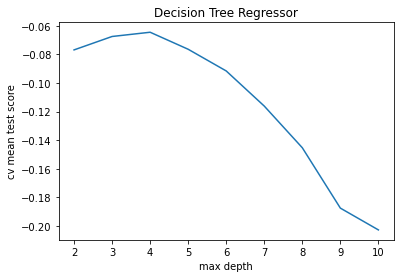

In [31]:
plt.plot(range(2,11), gs_tree.cv_results_['mean_test_score'])
plt.title('Decision Tree Regressor')
plt.xlabel('max depth')
plt.ylabel('cv mean test score')
plt.show()

## Random Forest
배깅을 적용한 decision tree의 앙상블

(겁나 오래 걸림)

In [36]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'max_depth' : range(2,11)}
gs_rf = GridSearchCV(RandomForestRegressor(criterion='mae'), param_grid, refit=True, verbose=2)
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................................... max_depth=2, total= 2.2min
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


[CV] ...................................... max_depth=2, total= 2.2min
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total= 2.1min
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total= 2.1min
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total= 2.1min
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total= 2.8min
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total= 2.7min
[CV] max_depth=3 .....................................................
[CV] ...................................... max_depth=3, total= 2.7min
[CV] max_depth=3 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 167.0min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mae', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [37]:
gs_rf.best_params_

{'max_depth': 10}

In [38]:
# best parameter 적용
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    rf = RandomForestRegressor(criterion='mae', max_depth = gs_rf.best_params_['max_depth'])
    rf.fit(X_train[train_index], y_train[train_index])
    pred = rf.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

Random_Forest_cv_mae = np.mean(scores)
print('Random Forest Regressor, max_depth = {}'.format(gs_rf.best_params_['max_depth']))
print(f'Random Forest Regressor cv_mae_score = {Random_Forest_cv_mae}\n')

Random Forest Regressor, max_depth = 10
Random Forest Regressor cv_mae_score = 16.018923118809663



In [57]:
gs_rf.cv_results_['mean_test_score']

array([-0.07362996, -0.0596806 , -0.04598293, -0.03756049, -0.02857273,
       -0.01917088, -0.01030769, -0.00257796,  0.00533108])

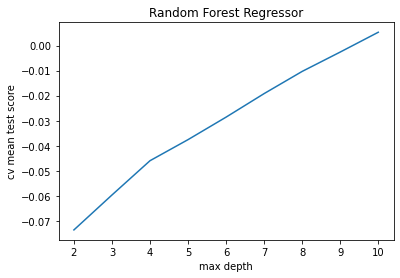

In [39]:
plt.plot(range(2,11), gs_rf.cv_results_['mean_test_score'])
plt.title('Random Forest Regressor')
plt.xlabel('max depth')
plt.ylabel('cv mean test score')
plt.show()

feature importance

In [54]:
# feature_importance: 가장 중요한 feature 인덱스 순으로 정렬
fi = rf.feature_importances_.tolist()
fi_sort = sorted(fi, reverse=True)
feature_importance = []
for i in range(14):
    feature_importance.append(fi.index(fi_sort[i]))

# 중요도 높은 feature 순서대로 선택하여 훈련
cv_mae_selected = []
for i in range(1,2):
#for i in range(1,15):
    X_train_selected = X_train[:,feature_importance[:i]]
    kf = KFold(n_splits=5)
    scores = []
    for train_index, test_index in kf.split(X_train_selected):
        rf = RandomForestRegressor(criterion='mae', max_depth = gs_rf.best_params_['max_depth'])
        rf.fit(X_train_selected[train_index], y_train[train_index])
        pred = rf.predict(X_train_selected[test_index])
        scores.append(mae(y_train[test_index], pred))
    cv_mae = np.mean(scores)
    cv_mae_selected.append(cv_mae)
    print(i, '-fold')

1 -fold


In [56]:
cv_mae_selected

[16.33400911550529]

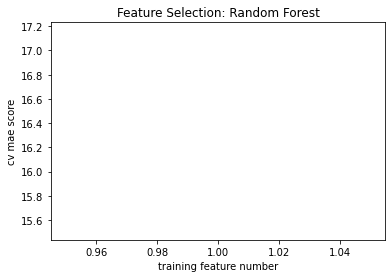

In [55]:
# feature selection 시각화
plt.plot(range(1,2), cv_mae_selected)
#plt.plot(range(1,15), cv_mae_selected)
plt.title('Feature Selection: Random Forest')
plt.xlabel('training feature number')
plt.ylabel('cv mae score')
plt.show()

## Gradient Boosting Regressor
부스팅을 적용한 decision tree의 앙상블

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {'max_depth': range(2,6),
              'learning_rate': [0.05, .1]}
gs_gbr = GridSearchCV(RandomForestRegressor(criterion='mae'), param_grid, refit=True, verbose=2)
gs_gbr.fit(X_train, y_train)

In [ ]:
# best parameter 적용
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    gbr = GradientBoostingRegressor(criterion='mae', max_depth = gs_gbr.best_params_['max_depth'], learning_rate = gs_gbr.best_params_['learning_rate'])
    gbr.fit(X_train[train_index], y_train[train_index])
    pred = gbr.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

GBR_cv_mae = np.mean(scores)
print('Gradient Boosting Regressor, max_depth = {0}, learning_rate = {1}'.format(gs_gbr.best_params_['max_depth'], gs_gbr.best_params_['learning_rate']))
print(f'Gradient Boosting Regressor cv_mae_score = {GBR_cv_mae}\n')

In [ ]:
plt.plot(range(2,6), gs_gbr.cv_results_['mean_test_score'])
plt.title('Gradient Boosting Regressor')
plt.xlabel('max depth (learning_rate={})'.format(gs_gbr.best_params_['learning_rate']))
plt.ylabel('cv mean test score')
plt.show()

feature selection

In [ ]:
# feature_importance: 가장 중요한 feature 인덱스 순으로 정렬
fi = gbr.feature_importances_.tolist()
fi_sort = sorted(fi, reverse=True)
feature_importance = []
for i in range(14):
    feature_importance.append(fi.index(fi_sort)[i]))

# 중요도 높은 feature 순서대로 선택하여 훈련
cv_mae_selected = []
for i in range(1,15): 
    X_train_selected = X_train[:,feature_importance[:i]]
    kf = KFold(n_splits=5)
    scores = []
    for train_index, test_index in kf.split(X_train_selected):
        gbr = GradientBoostingRegressor(criterion='mae', max_depth = gs_gbr.best_params_['max_depth'], learning_rate = gs_gbr.best_params_['learning_rate'])
        gbr.fit(X_train_selected[train_index], y_train[train_index])
        pred = gbr.predict(X_train_selected[train_index])
        scores.append(mae(y_train[train_index], pred))
    cv_mae = np.mean(scores)
    cv_mae_selected.append(cv_mae) # 총 14개 저장되어야 함

In [ ]:
# feature selection 시각화
plt.plot(range(1,15), cv_mae_selected)
plt.title('Feature Selection: Gradient Boosting Regressor')
plt.xlabel('training feature number')
plt.ylabel('cv mae score')
plt.show()

## XGBoost (GPU 켜고 돌리기)

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
parameters = {'nthread':[4],
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .1],
              'max_depth': [2, 3, 4, 5],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 3,
                        #n_jobs = 5,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train, y_train)
# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.4min finished


0.04918227752623727
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [ ]:
# best parameter 적용
kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    xgb = XGBRegressor(learning_rate = xgb_grid.best_params_['learning_rate']
                       max_depth = xgb_grid.best_params_['max_depth'],
                       verbose = True)
    xgb.fit(X_train[train_index], y_train[train_index])
    pred = xgb.predict(X_train[test_index])
    scores.append(mae(y_train[test_index], pred))

XGB_cv_mae = np.mean(scores)
print('XGBoost, learning_rate = {0}, max_depth = {1}'.format(xgb_grid.best_params_['learning_rate'], xgb_grid.best_params_['max_depth']))
print(f'XGBoost cv_mae_score = {XGB_cv_mae}\n')

In [ ]:
plt.plot(range(2,6), xgb_grid.cv_results_['mean_test_score'])
plt.title('XGBoost')
plt.xlabel('max depth')
plt.ylabel('cv mean test score')
plt.show()

# PCA
제일 좋은 모델로!

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
